# Recreating the main figure from kinematics-and-rotation using both periodic and 'non-periodic' data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from dispersion import *

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [44]:
gaia_mc0 = pd.read_csv("../../kinematics-and-rotation/gaia_mc2.csv")
print(np.shape(gaia_mc0))

# Cut out visual binaries.
gaia_mc1 = gaia_mc0.iloc[gaia_mc0.flag.values == 1]
print(np.shape(gaia_mc1), "no visual binaries or subgiants")

# Cut out stars with large vb uncertainties.
m = gaia_mc1.vb_err.values < 1.
print(np.shape(gaia_mc1.iloc[m]), "no large vb uncertainties")

m &= gaia_mc1.phot_g_mean_mag.values < 16.
print(np.shape(gaia_mc1.iloc[m]), "no faint stars")

# Cut out rapid rotators (synchronized binaries)
m &= gaia_mc1.age.values > .5
print(np.shape(gaia_mc1.iloc[m]), "no rapid rotators")

# Cut out very hot and very cold stars. The hot limit is usually 5000 and the cool usually 3500
mint, maxt = 3500, 6500
m &= (gaia_mc1.color_teffs.values < maxt) * (mint < gaia_mc1.color_teffs.values)
print(np.shape(gaia_mc1.iloc[m]), "no hot or cold stars")

# Try cutting out stars with latitudes greater than bmax degrees
# bmax = 20
bmax = 15
bmin = 10
m &= (gaia_mc1.b.values < bmax) * (bmin < gaia_mc1.b.values)
print(np.shape(gaia_mc1.iloc[m]), "no high latitude stars")

gaia_mc = gaia_mc1.iloc[m]

# # Restrict to stars with Vz
# m &= np.isfinite(gaia_mc1.vz.values)
# print(np.shape(gaia_mc1.iloc[m]), "only stars with Vz")

# Remove velocity outliers
v_clipped, clipping_mask = sigma_clip(gaia_mc.vb.values, 3)
gaia_mc = gaia_mc.iloc[clipping_mask]

gaia_mc["Rvar"] = gaia_mc.Rper.values

(31357, 133)
(11700, 133) no visual binaries or subgiants
(11436, 133) no large vb uncertainties
(11272, 133) no faint stars
(10586, 133) no rapid rotators
(10489, 133) no hot or cold stars
(4651, 133) no high latitude stars
niter =  5 78 stars removed kurtosis =  0.15104151601432392


Load non-periodic data with cuts.

In [69]:
non_per = pd.read_csv("gaia_mc_non_periodic.csv")
# non_per = pd.read_csv("../data/gaia_mc_non_periodic_rvar_append.csv")
m = non_per.Prot.values > 0
non_per = non_per.iloc[m]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [82]:
df = pd.concat([gaia_mc, non_per])
# df = gaia_mc

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [83]:
x = df.color_teffs.values
v = df.vb.values
verr = df.vb_err.values
xerr = np.ones_like(x)*100
xlim = (maxt + 100, mint - 200)

tbins = np.linspace(min(x), max(x), 10)

In [84]:
y = df.Prot.values

period_bins = 10**np.linspace(np.log10(7), np.log10(80), 9)
mid_period_bins = period_bins[:-1] + .5*np.diff(period_bins)
period_masks = select_stars(df, period_bins, "Prot")

pds, pderrs = [np.zeros((len(period_bins), len(tbins[:-1]))) for i in range(2)]

In [85]:
for i, m in enumerate(period_masks):
    d, derr, k, kerr = MC_dispersion(x[m], v[m], xerr[m], verr[m], tbins, 1000, method="std")
    derr = err_on_sample_std_dev(d, len(x[m]))
    pds[i, :] = d
    pderrs[i, :] = err_on_sample_std_dev(d, len(x[m]))

    midbin = np.diff(tbins)*.5+tbins[:-1]

100%|██████████| 1000/1000 [00:01<00:00, 699.87it/s]


Text(0, 0.5, 'Prot')

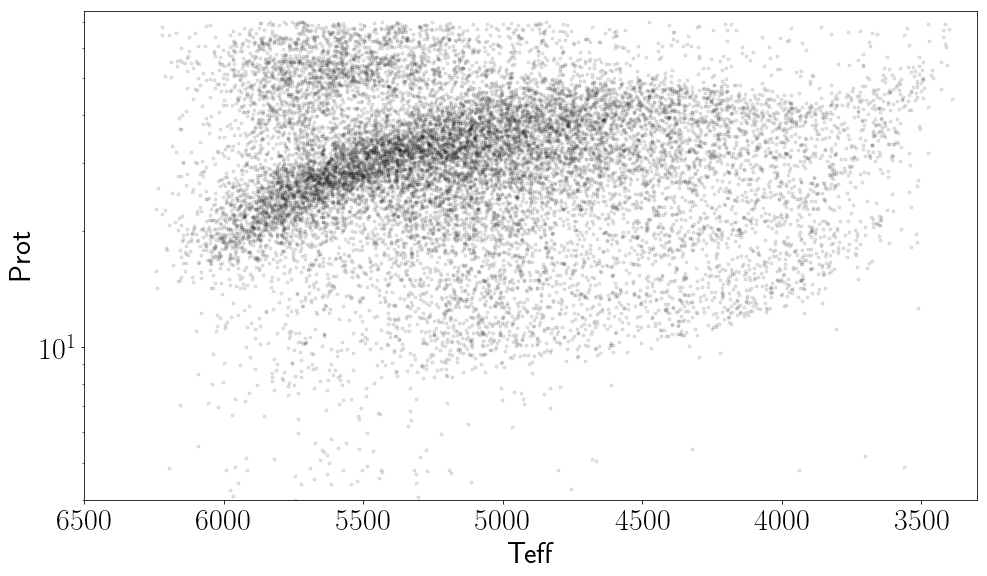

In [86]:
plt.figure(figsize=(16, 9))
plt.plot(x, y, "k.", alpha=.1)
plt.xlim(6500, xlim[1])
plt.ylim(4, 75)
plt.yscale("log")
plt.xlabel("Teff")
plt.ylabel("Prot")

# for i, m in enumerate(period_masks):
    
#     for j in range(len(tbins)-1):
#         tm = (x[m] > tbins[j]) * (x[m] < tbins[j+1])
#         cb1 = plt.plot(x[m][tm], y[m][tm], "k.", alpha=.1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


Text(0.5, 0, '$\\mathrm{T_{eff}~[K]}$')

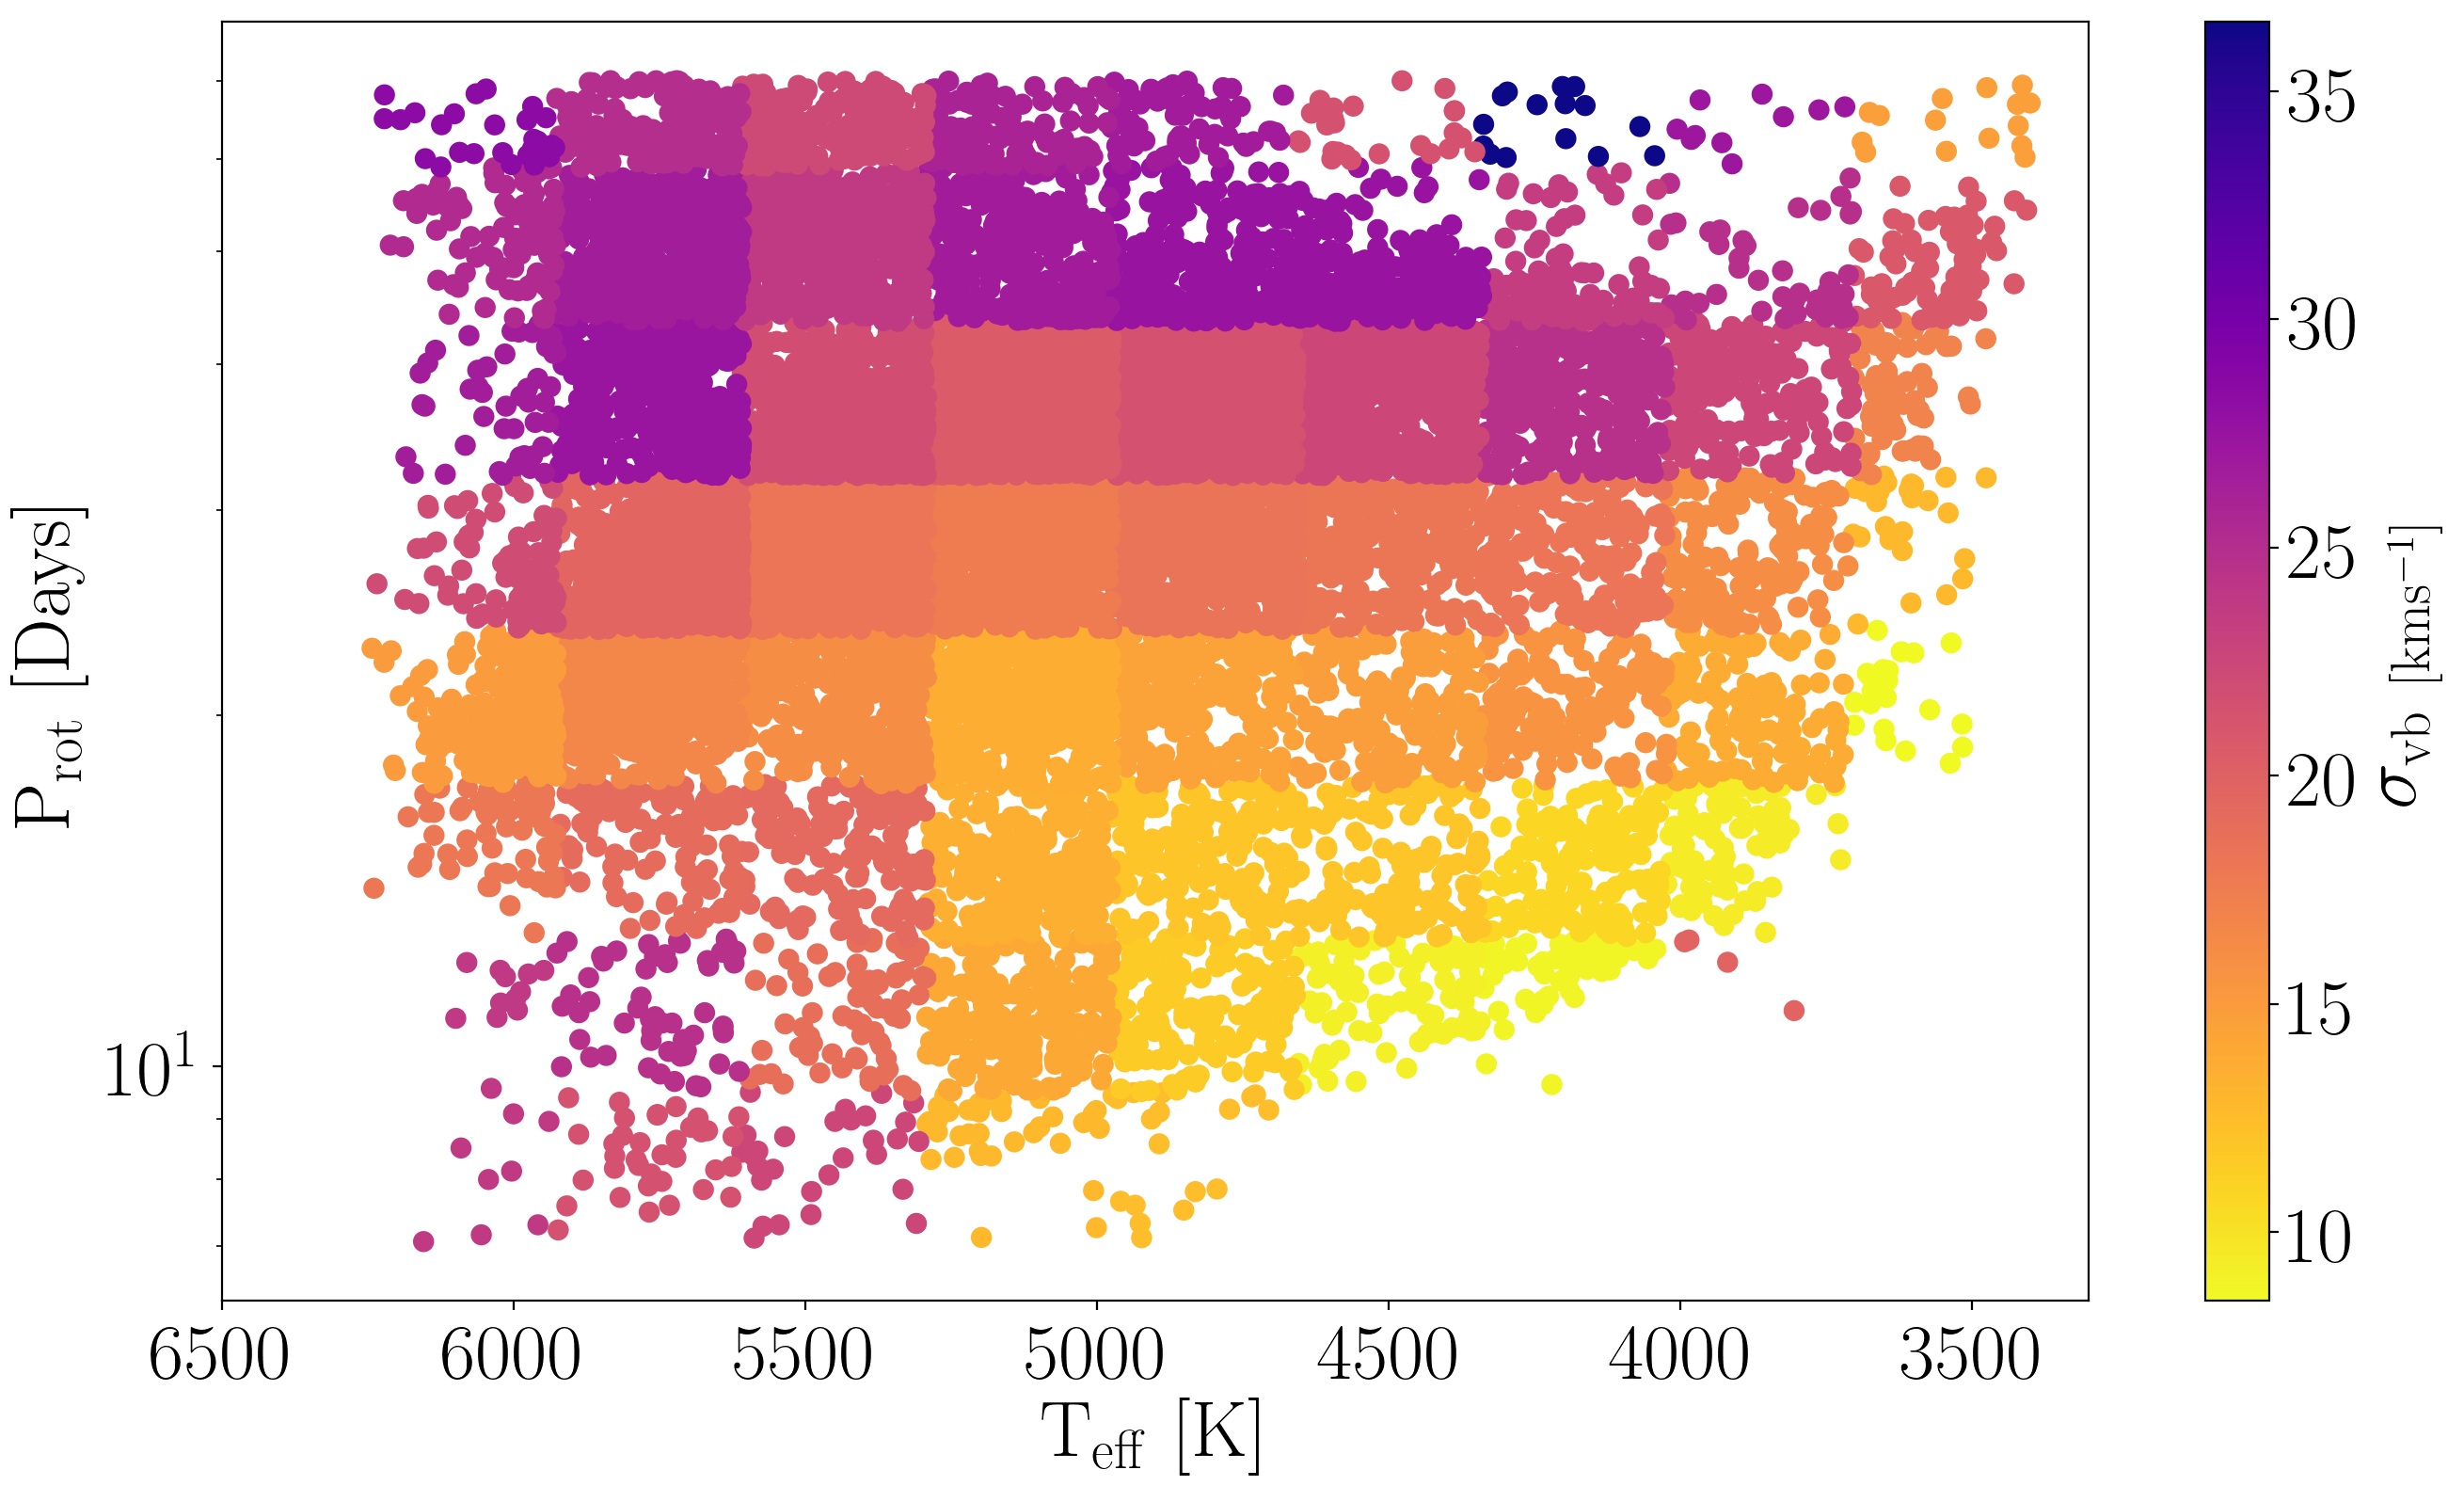

In [87]:
cmap = plt.cm.get_cmap('plasma_r')
pvmin, pvmax = np.min(pds[pds > 0]), np.max(pds[np.isfinite(pds)])
pcolor_values = (pds - pvmin)/(pvmax - pvmin)
prgba_plasma = cmap(pcolor_values)

fig = plt.figure(figsize=(16, 9), dpi=200)
ax = fig.add_subplot(111)

for i, m in enumerate(period_masks):
    
    for j in range(len(tbins)-1):
        tm = (x[m] > tbins[j]) * (x[m] < tbins[j+1])
        cb1 = plt.scatter(x[m][tm], y[m][tm], c=np.ones_like(y[m][tm])*pds[i, j],
                          vmin=pvmin, vmax=pvmax, rasterized=True, zorder=1, s=50,
                          cmap="plasma_r")


plt.colorbar(cb1, label="$\sigma_\mathrm{vb~[kms^{-1}]}$")
ax.set_ylabel("$\mathrm{P_{rot}~[Days]}$")
ax.set_xlim(6500, xlim[1])
ax.set_yscale("log")
ax.set_xlabel("$\mathrm{T_{eff}~[K]}$")

Text(0, 0.5, 'Rvar')

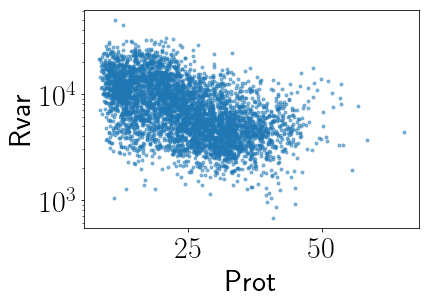

In [88]:
plt.plot(df.Prot, df.Rvar, ".", alpha=.5)
plt.yscale("log")
plt.xlabel("Prot")
plt.ylabel("Rvar")

(5750, 3200)

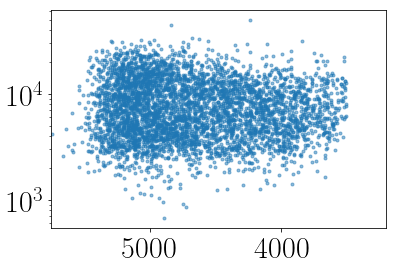

In [89]:
plt.plot(df.color_teffs, df.Rvar, ".", alpha=.5)
plt.yscale("log")
plt.xlim(5750, 3200)

(0.5, 6)

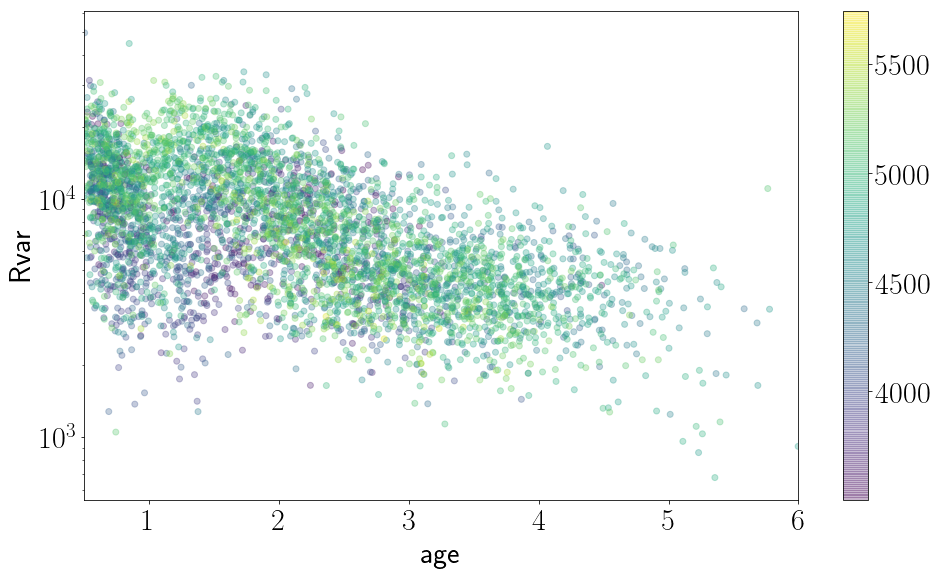

In [94]:
plt.figure(figsize=(16, 9))
plt.scatter(df.age, df.Rvar, c=df.color_teffs, alpha=.3)
plt.colorbar()
plt.yscale("log")
plt.xlabel("age")
plt.ylabel("Rvar")
plt.xlim(.5, 6)